In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy import array
from game2048.game import Game
from game2048.agents import ExpectiMaxAgent, Agent
from keras.callbacks import ReduceLROnPlateau as RLRL
from game2048.displays import Display
from keras.callbacks import TensorBoard

# In[2]:


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from sklearn.preprocessing import OneHotEncoder
import numpy as np

ohe = OneHotEncoder()
ohe.fit([ [0], [2], [4], [8], [16], [32], [64], [128], [256], [512], [1024], [2048]])

def board_transform(board_tO_onehot, gamesize=4):
    """transform the board by one-hot encoding"""
    new_board = ohe.transform(board_tO_onehot[0][0]).toarray()
    for i in range(gamesize):
        for j in range(gamesize):
            if i == 0 and j == 0:
                continue
            element = board_tO_onehot[i][j]
            new_element = ohe.transform(element).toarray()
            new_board = np.vstack((new_board, new_element))
    # print(new_board)
    y = np.expand_dims(new_board, axis=0)
    return y

label_ohe = OneHotEncoder()
label_ohe.fit([[0],[1],[2],[3]])

def label_transform(label_to_onehot):
    tmp_label = label_ohe.transform(label_to_onehot).toarray()
    return np.array(tmp_label).reshape(1, -1)
    #return label_to_onehot


# In[3]:


game_size = 4
zit_score_to_win = 2048

n_epoch = 10
n_steps_per_epoch = 1000
every_epoch = 1
ite = 1000 # the number of iteration to generate

data_path = '/home/srtp/ML/2048-api-master/2048-api-master/cnn_train_data/'
tenb_path = "/home/srtp/ML/2048-api-master/2048-api-master/my_log_dir/"

count = 0
min_score=0
max_score=11
rnn_filter = 64

drop = 0.15

lr= 0.001
decay= lr/n_epoch
game = Game(game_size, zit_score_to_win)


# In[4]:


def get_score(board):
    # input a 16*12 tensor
    # notice that return is a number between 0~11(reflect 0~2048)
    score = 0
    for number in board:
        max_num = np.argmax(number) 
        if max_num > score:
            score = max_num
    return score


def generate_array_from_file(data_path):
    global count
    while 1:
        load_path = os.path.join(data_path, 'cnn_dataset_'+str(count)+'.npz')

        initial_data = np.load(load_path)['arr_0']
        initial_label = np.load(load_path)['arr_1']
        """
        if len(train_label)>max_index:
            train_data = train_data[min_index:max_index]
            train_label = train_label[min_index:max_index]
        else:
            train_data = train_data[min_index:]
            train_label = train_label[min_index:]
        """
        for i in range(initial_data.shape[0]):
            if get_score(initial_data[i]) >= min_score:
                break


        if max_score==11:
            train_data = initial_data[i:]
            train_label = initial_label[i:]
        else:

            train_data = np.expand_dims(initial_data[i],axis=0)
            train_label = initial_label[i]
            i = i+1

            while 1:
                if get_score(initial_data[i])<max_score:
                    train_data = np.vstack((train_data, np.expand_dims(initial_data[i],axis=0)))
                    train_label = np.vstack((train_label, initial_label[i]))
                    i = i+1
                else:
                    break
        count = count+1
        if count>= ite:
            count = 0
        train_data = train_data.reshape((train_data.shape[0],4,4,12))
        yield (train_data, train_label)

def generate_val_dataset(data_path, num):
    load_path = os.path.join(data_path, 'cnn_dataset_'+str(num)+'.npz')

    initial_data = np.load(load_path)['arr_0']
    initial_label = np.load(load_path)['arr_1']
    """
    if len(val_label)>max_index:
        val_data = val_data[min_index:max_index]
        val_label = val_label[min_index:max_index]

    else:
        val_data = val_data[min_index:]
        val_label = val_label[min_index:]
    """
    print(initial_data.shape)
    for i in range(initial_data.shape[0]):
        # print(get_score(initial_data[i]))
        if get_score(initial_data[i]) >= min_score:
            break
        
    if max_score==11:
        val_data = initial_data[i:]
        val_label = initial_label[i:]
    else:
        val_data = np.expand_dims(initial_data[i],axis=0)
        val_label = initial_label[i]
        i = i+1

        while 1:
            if get_score(initial_data[i])<max_score:
                val_data = np.vstack((val_data, np.expand_dims(initial_data[i],axis=0)))
                val_label = np.vstack((val_label, initial_label[i]))
                i = i+1
            else:
                break

    #val_data, _val_label = shuffle(val_data, val_label, random_state=0)
    val_data = val_data.reshape((val_data.shape[0],4,4,12))
    #val_data = np.pad(val_data,((0,0),(0,0),(2,2)),'constant')
    #val_data = np.expand_dims(val_data, axis = 3)
    return val_data, val_label


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 4, 12)     0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4, 4, 12)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 64)     1600        dropout_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 64)     1600        dropout_1[0][0]                  
__________________________________________________________________________________________________
conv2d_3 (

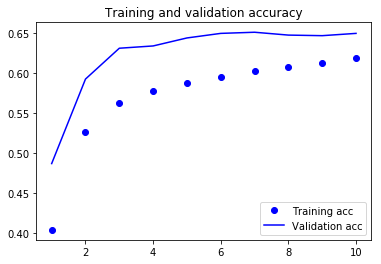

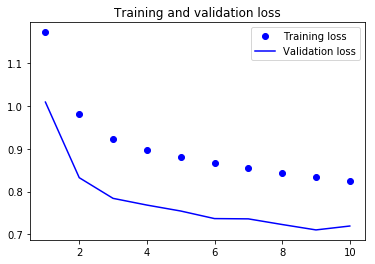

In [2]:
from keras.models import Sequential
from keras.layers import  Flatten, Dense, Dropout, Activation, Reshape
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,LSTM,concatenate,Bidirectional
from keras.layers import Conv1D

from keras.optimizers import RMSprop,SGD,Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau as RLRL

from keras import Model, Input
import keras
"""
inputs = Input((4,4,12))
layer1_tensor1 = Conv2D(128, (2, 1), strides=(1, 1), activation='relu')(inputs)
layer1_tensor2 = Conv2D(128, (1, 2), strides=(1, 1), activation='relu')(inputs)
layer2_tensor1 = Conv2D(128, (1, 2), strides=(1, 1), activation='relu')(layer1_tensor1)
layer2_tensor2 = Conv2D(128, (2, 1), strides=(1, 1), activation='relu')(layer1_tensor1)
layer2_tensor3 = Conv2D(128, (1, 2), strides=(1, 1), activation='relu')(layer1_tensor2)
layer2_tensor4 = Conv2D(128, (2, 1), strides=(1, 1), activation='relu')(layer1_tensor2)
layer2 = keras.layers.concatenate([Flatten()(layer2_tensor1),
Flatten()(layer2_tensor2),
Flatten()(layer2_tensor3),
Flatten()(layer2_tensor4)])

layer3 = Dense(2000, activation='relu')(layer2)
layer4 = Dense(2000, activation='relu')(layer3)
layer5 = Dense(500, activation='relu')(layer4)
outputs = Dense(4, activation='softmax')(layer5)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
"""

inputs = Input((4,4,12))
cnn = Dropout(0.1)(inputs)
"""
conv1 = Conv2D(64, (1, 2), strides=(1, 1), kernel_initializer='he_uniform',
               padding='same',activation='relu')(zit_inputs)
conv1 = Conv2D(128, (1, 1), strides=(1, 1), kernel_initializer='he_uniform',
               padding='same',activation='relu')(conv1)

#conv2 = Conv2D(512, (1, 1), strides=(1, 1), kernel_initializer='he_uniform',
#               padding='same',activation='relu')(conv1)

conv1 = Conv2D(64, (2, 1), strides=(1, 1), kernel_initializer='he_uniform',
               padding='same',activation='relu')(conv1)
"""

filters1 = 64
filters2 = 256
dense_filter = 200
cnn1 = Conv2D(filters1, (1,2),strides=(1, 1), kernel_initializer='he_uniform',
               padding='same',activation='relu')(cnn)

cnn2 = Conv2D(filters1, (2,1),strides=(1, 1), kernel_initializer='he_uniform',
               padding='same',activation='relu')(cnn)

cnn11 = Conv2D(filters2, (1,2),strides=(1, 1), kernel_initializer='he_uniform',
               padding='same',activation='relu')(cnn1)

cnn12 = Conv2D(filters2, (2,1),strides=(1, 1), kernel_initializer='he_uniform',
               padding='same',activation='relu')(cnn1)

cnn21 = Conv2D(filters2, (1,2),strides=(1, 1), kernel_initializer='he_uniform',
               padding='same',activation='relu')(cnn2)

cnn22 = Conv2D(filters2, (2,1),strides=(1, 1), kernel_initializer='he_uniform',
               padding='same',activation='relu')(cnn2)



con1 = concatenate([cnn11,cnn12,cnn21,cnn22,cnn1,cnn2])

con1 = Reshape(target_shape=(16, filters1*2+filters2*4))(con1)

rnn1 = LSTM(200, return_sequences = True)(con1)
rnn1 = LSTM(200, return_sequences = False)(rnn1)
dense1 = Dense(dense_filter, activation='relu')(rnn1)
dense1 = Dense(dense_filter, activation='relu')(dense1)



"""
rnn = Reshape(target_shape = (16,12))(zit_inputs)

rnn = LSTM(128, return_sequences = True)(rnn)
rnn = BatchNormalization()(rnn)
# rnn = LSTM(256, return_sequences = True)(rnn)
rnn = LSTM(128, return_sequences = False)(rnn)

rnn = BatchNormalization()(rnn)
rnn = Dropout(0.2)(rnn)
dense2 = Dense(256, activation='relu')(rnn)


"""


"""
mid= Dense(512, activation='relu',kernel_initializer='he_uniform')(mid)
mid= BatchNormalization()(mid)
mid = Activation('relu')(mid)
mid = Dropout(0.2)(mid)

mid= Dense(512, activation='relu',kernel_initializer='he_uniform')(mid)
mid= BatchNormalization()(mid)
mid = Activation('relu')(mid)
mid = Dropout(0.2)(mid)
"""
outputs = Dense(4, activation='softmax')(dense1)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

_val_data, _val_label = generate_val_dataset(data_path,1498)
val_data_, val_label_ = generate_val_dataset(data_path,1499)

val_data = np.vstack((_val_data, val_data_))
val_label = np.vstack((_val_label, val_label_))

# x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, train_size=batch_size)
history = model.fit_generator(generate_array_from_file(data_path),
                            steps_per_epoch=n_steps_per_epoch, 
                            epochs = n_epoch,
                            validation_data=(val_data,val_label))


# callbacks=[TensorBoard(log_dir=tenb_path),
#RLRL(monitor='val_loss',factor=0.5, patience=5,min_lr=1e-37)])

model.save('/home/srtp/ML/2+4_model.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()